In [1]:
# !pip install tensorflow


In [1]:
import sys
from pathlib import Path

# Zum übergeordneten Ordner 'src' wechseln
current_path = Path().resolve()
src_path = current_path.parents[4]  # Zwei Stufen nach oben

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

src_path


WindowsPath('C:/Users/Nasiba/Documents/1 Master Data Science/Projektpraktikum/WebScience24')

In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import  classification_report, confusion_matrix
pd.set_option('display.max_colwidth', None)

from vector_functions import vectorize_word2vec,  vectorize_word2vec_test_data
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping

#### Beladung der Daten

In [ ]:

source_filepath_name = os.path.abspath(os.path.join(src_path, 'data/twitter_hate-speech/train_cleaned.csv'))

df_cleaned = pd.read_csv(source_filepath_name, encoding='utf-8', index_col=0)

source_filepath_name_test = os.path.abspath(os.path.join(src_path, 'data/twitter_hate-speech/test_cleaned.csv'))

df_cleaned_test = pd.read_csv(source_filepath_name_test, encoding='utf-8', index_col=0)

print(df_cleaned.count())

label            20289
tweet            20289
tweet_cleaned    20288
user_handle      20289
hashtags         20289
emojis            4220
dtype: int64


### Vektorisierung

In [4]:
X_train_w2v, X_test_w2v, y_train_wv, y_test, w2v_model = vectorize_word2vec(df=df_cleaned, text_column ="tweet_cleaned", label_column="label")



Shape nach Oversampling: (26550,)
(26550,)
(26550,)


c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\Training\Phase_1\vector_functions.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


Originaltext: cinemaaawards final rehearsals gearing up for the evening butterflies stage  hope You all like it
Tokenisierte Version: ['upbeat', 'pop', 'rock', 'track', 'with', 'elements', 'of', 'dance', 'music', 'ideal', 'for', 'your', 'media', 'projects', 'commercials', 'tv']
❌ Fehlende Token (Beispiele): ['cinemaaawards', '‘criminal', 'minds’', 'horsepower', 'chamilia', 'inventory', 'cranberry', 'chamilia', 'thisthx', 'hires', 'skipton', 'djhumility', 'ojb', 'ripojb', 'areacodemixshow', 'gfe', 'letsplay', 'midlands', 'irelands', 'sarita']
Gesamtanzahl fehlender Token: 34
Länge von X_train_w2v: 26550
Erste Sequenz: [[ 7.2245002e-02 -8.1457533e-02 -1.6451648e-01 ... -7.7877700e-02
  -2.9157137e-02  5.3321883e-02]
 [ 1.0279596e-01  3.1240299e-01 -5.6232727e-01 ... -1.7036304e-01
   4.4106585e-01 -2.0160399e-01]
 [ 2.8689569e-01 -1.2670660e-01 -3.5295707e-01 ... -1.5925269e-01
  -3.1732953e-01 -8.1467211e-02]
 ...
 [-6.2909767e-02 -2.7303562e-02 -3.6288824e-05 ... -3.8944472e-02
  -1.05

In [7]:
X_test_w2v_data, y_test_w2v_data, w2v_model = vectorize_word2vec_test_data(df=df_cleaned_test, text_column ="tweet_cleaned", label_column="label")

Originaltext: model i love You take with You all the time in ur mobile phone  kissing face with smiling eyes smiling face with sunglasses mouth tongue sweat droplets sweat droplets sweat droplets
Tokenisierte Version: model i love You take with You all the time in ur mobile phone  kissing face with smiling eyes smiling face with sunglasses mouth tongue sweat droplets sweat droplets sweat droplets
❌ Fehlende Token (Beispiele): []
Gesamtanzahl fehlender Token: 0


#### Modeltraining mit anderen Parametern

(Aktivierungsfunktion in der Dense-Schicht zu sigmoid ändern,class_wight hinzufügen)

In [5]:
print(type(X_train_w2v))
print(len(X_train_w2v))  # Falls es eine Liste ist
print(X_train_w2v.shape) 

<class 'numpy.ndarray'>
26550
(26550, 93, 200)


In [6]:
samples_w2v, max_seq_len_w2v, vector_size_w2v = X_train_w2v.shape
num_classes_w2v = len(np.unique(y_train_wv))

print(samples_w2v)
print(max_seq_len_w2v)
print (vector_size_w2v)


26550
93
200


In [9]:

print(X_train_w2v[0])  # Ersten Trainingssatz ausgeben
print(X_train_w2v[0].shape)  # Sollte (max_seq_len, vector_size) sein

[[-2.68113625e-04  1.18215678e-04  2.55167484e-03  4.50463640e-03
  -4.65147477e-03 -3.55840451e-03  3.22943623e-03  4.48649423e-03
  -2.50771409e-03 -1.88168581e-03  3.69025231e-03 -7.66735699e-04
  -2.26830668e-03  3.27702588e-03 -2.43008020e-03 -9.08008835e-04
   1.43828988e-03  4.95936896e-04 -4.14260756e-03 -4.72440897e-03
   3.65588302e-03  2.53513106e-03  3.37884668e-03  3.81432765e-04
   3.17544513e-03 -1.70268293e-03 -4.73200693e-04  2.88428669e-03
  -3.76081886e-03 -1.96805177e-03 -3.75579111e-03 -4.65021119e-04
   4.76905936e-03 -3.65958340e-03 -1.16688432e-03 -9.68870532e-04
   4.03871853e-03 -2.96544796e-03  2.25812200e-05 -2.37686699e-03
  -4.80177533e-03  2.50364654e-03 -4.37979260e-03 -2.19591265e-03
  -1.75499918e-05 -1.48090723e-04 -3.83062009e-03  4.80737165e-03
   2.49102898e-03  4.61657159e-03 -4.07895865e-03  2.24789907e-03
  -2.06853799e-03  4.12268040e-04  4.24931012e-03 -2.23108823e-03
   2.25875014e-03 -3.39348009e-03 -1.77424436e-03  4.69925394e-03
  -7.88826

In [8]:
print(len(w2v_model.wv))  # Anzahl der trainierten Wörter
print(w2v_model.wv.key_to_index) 



20100
{'the': 0, 'to': 1, 'a': 2, 'face': 3, 'i': 4, 'with': 5, 'is': 6, 'and': 7, 'you': 8, 'of': 9, 'in': 10, 'for': 11, 'my': 12, 'it': 13, 'smiling': 14, 'on': 15, 'this': 16, 'be': 17, 'love': 18, 'not': 19, 'heart': 20, 'am': 21, 'are': 22, 'day': 23, 'so': 24, 'have': 25, 'that': 26, 'do': 27, 'at': 28, 'me': 29, 'eyes': 30, 'happy': 31, ';': 32, 'all': 33, 'your': 34, 'just': 35, 'we': 36, 'will': 37, '-': 38, 'up': 39, 'when': 40, 'what': 41, 'red': 42, 'like': 43, 'from': 44, 'life': 45, 'but': 46, '…': 47, 'out': 48, 'was': 49, 'today': 50, 'new': 51, 'skin': 52, 'now': 53, 'get': 54, 'tone': 55, 'people': 56, 'bihday': 57, 'as': 58, 'by': 59, 'about': 60, 'no': 61, 'our': 62, 'hands': 63, 'cant': 64, 'how': 65, 'see': 66, 'grinning': 67, 'one': 68, 'can': 69, 'they': 70, 'time': 71, 'joy': 72, 'positive': 73, 'heart-eyes': 74, 'more': 75, 'good': 76, 'smile': 77, 'tears': 78, 'crying': 79, 'go': 80, 'he': 81, 'thankful': 82, 'an': 83, 'You': 84, 'fathers': 85, 'who': 86, 'w

In [8]:
print("Größe des Word2Vec-Wortschatzes:", len(w2v_model.wv))


Größe des Word2Vec-Wortschatzes: 20100


In [9]:
print("Durchschnittswerte:", np.mean(X_train_w2v))
print("Standardabweichung:", np.std(X_train_w2v))
print("Erster Satz als Vektor:", X_train_w2v[0])


Durchschnittswerte: -0.0021405612043117767
Standardabweichung: 0.35577629078070766
Erster Satz als Vektor: [[ 0.072245   -0.08145753 -0.16451648 ... -0.0778777  -0.02915714
   0.05332188]
 [ 0.10279596  0.31240299 -0.56232727 ... -0.17036304  0.44106585
  -0.20160399]
 [ 0.28689569 -0.1267066  -0.35295707 ... -0.15925269 -0.31732953
  -0.08146721]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [6]:
print("Größe des Word2Vec-Wortschatzes:", len(w2v_model.wv))
print("Einige Wörter aus dem Vokabular:", list(w2v_model.wv.key_to_index.keys())[:10])
print("Erste Sequenz (erste 5 Wörter):", X_train_w2v[0][:5])  

Größe des Word2Vec-Wortschatzes: 20100
Einige Wörter aus dem Vokabular: ['the', 'to', 'a', 'face', 'i', 'with', 'is', 'and', 'you', 'of']
Erste Sequenz (erste 5 Wörter): [[ 3.27348262e-02 -2.34664343e-02 -3.07297278e-02  1.49188768e-02
   2.24003568e-02 -3.14368159e-02  6.65213820e-03  9.60880890e-02
  -3.78570929e-02 -9.13944840e-03 -3.25518139e-02 -1.04184067e-02
   8.04260373e-03  9.23994556e-02 -1.15891835e-02 -1.69158145e-03
  -2.17551738e-02  5.75998798e-03  3.57785472e-03 -5.58099858e-02
   6.45075291e-02 -2.85774972e-02 -5.01406007e-02  1.95470508e-02
  -3.86907998e-03 -9.08937026e-03  4.99579404e-03 -3.41665111e-02
   3.56880948e-03  9.00624134e-03  6.96854219e-02  2.65732827e-03
  -3.04795802e-02 -2.02392135e-02  1.40188215e-02  3.06855813e-02
   4.35685106e-02  5.45472614e-02  7.09090265e-04 -3.93907502e-02
   7.58846989e-03 -1.32120214e-02 -1.64371207e-02  3.89794111e-02
   2.85117957e-03  2.03959756e-02 -5.97546846e-02 -5.49353426e-03
   3.93285714e-02  2.61711981e-02 -9.9

In [10]:
missing_words = 0
total_words = 0

for sentence in X_train_w2v:
    for word_vector in sentence:
        if np.all(word_vector == 0):  # Falls der Vektor nur aus Nullen besteht
            missing_words += 1
        total_words += 1

print(f"❌ Fehlende Wörter: {missing_words}/{total_words} ({(missing_words / total_words) * 100:.2f}%)")

❌ Fehlende Wörter: 2105029/2469150 (85.25%)


In [11]:
word = "cinemaaawards"  # Ersetze mit einem Wort aus deinen Daten
if word in w2v_model.wv:
    print(f"✅ Das Wort '{word}' ist im Modell.")
else:
    print(f"❌ Das Wort '{word}' fehlt im Modell!")


❌ Das Wort 'cinemaaawards' fehlt im Modell!


In [12]:

# Modellinitialisierung
model_w2v = Sequential()

# LSTM-Schicht
model_w2v.add(LSTM(units=128, input_shape=(max_seq_len_w2v, vector_size_w2v), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model_w2v.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model_w2v.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells
model_w2v.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall()])

class_weight = {0: 1, 1: 3} 
history_w2v = model_w2v.fit(
    X_train_w2v, np.array(y_train_wv),
    validation_data=(X_test_w2v, np.array(y_test)),
    epochs=10,
    batch_size=32,
    class_weight=class_weight,
    verbose=2
)
# Vorhersagen auf Testdaten
predictions_w2v = model_w2v.predict(X_test_w2v_data)
threshold = 0.35 
predicted_classes_w2v = (predictions_w2v > threshold).astype(int)




C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
830/830 - 86s - 103ms/step - accuracy: 0.6663 - loss: 0.9569 - recall: 0.9484 - val_accuracy: 0.2466 - val_loss: 1.3135 - val_recall: 0.9855
Epoch 2/10
830/830 - 97s - 116ms/step - accuracy: 0.5828 - loss: 1.0415 - recall: 0.9912 - val_accuracy: 0.2445 - val_loss: 1.2150 - val_recall: 0.9855
Epoch 3/10
830/830 - 84s - 101ms/step - accuracy: 0.5846 - loss: 1.0370 - recall: 0.9914 - val_accuracy: 0.2491 - val_loss: 1.1876 - val_recall: 0.9855
Epoch 4/10
830/830 - 92s - 110ms/step - accuracy: 0.6639 - loss: 0.9616 - recall: 0.9189 - val_accuracy: 0.0682 - val_loss: 1.0641 - val_recall: 1.0000
Epoch 5/10
830/830 - 81s - 98ms/step - accuracy: 0.5125 - loss: 0.9851 - recall: 0.9852 - val_accuracy: 0.6808 - val_loss: 1.0989 - val_recall: 0.6150
Epoch 6/10
830/830 - 81s - 98ms/step - accuracy: 0.6146 - loss: 0.9545 - recall: 0.9699 - val_accuracy: 0.4881 - val_loss: 1.0229 - val_recall: 0.9346
Epoch 7/10
830/830 - 81s - 98ms/step - accuracy: 0.5799 - loss: 1.0342 - recall: 0.9909 - 

#### Evauliation Word2Wec Ergebnisse

Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      0.00      0.00      8468
     Class 1       0.07      1.00      0.13       625

    accuracy                           0.07      9093
   macro avg       0.53      0.50      0.06      9093
weighted avg       0.94      0.07      0.01      9093

[[   2 8466]
 [   0  625]]


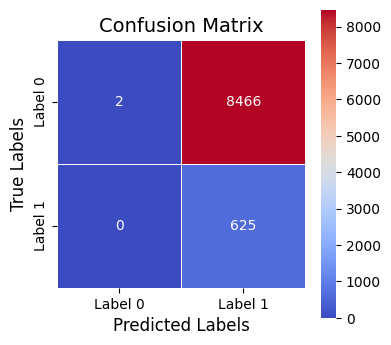

In [13]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_w2v_data, predicted_classes_w2v, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_w2v_data, predicted_classes_w2v)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()